This code will load the model information, generate the model definition, and run the model estimation using FSL

In [1]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting

%matplotlib inline
import matplotlib.pyplot as plt

datadir='/home/jovyan/ClassData/'
    
results_dir = '/home/jovyan/ClassData/LabResults'#os.path.abspath("../../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',datadir)

191107-21:36:25,728 nipype.utils INFO:
	 Running nipype version 1.3.0-rc1 (latest: 1.2.3)


/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Using data from /home/jovyan/ClassData/


In [2]:
from bids import BIDSLayout
layout = BIDSLayout(datadir,validate=False)
layout

BIDS Layout: .../home/jovyan/ClassData | Subjects: 10 | Sessions: 0 | Runs: 30

In [3]:
#Psych60 Now lets look at what our data layout is a little closer.
#BIDS format is described in more depth here http://bids.neuroimaging.io/
#Please go and read up a little on BIDS and why it is important

In [4]:
layout.get_subjects()

['sid000006',
 'sid000118',
 'sid000689',
 'sid000747',
 'sid001548',
 'sid001550',
 'sid001551',
 'sid001560',
 'sid001561',
 'sid001562']

In [5]:
layout.get_tasks()

['mental']

In [6]:
source_epi=layout.get(task="mental", extensions="nii")[0]
layout.get(task="mental", extensions="nii")[0].path

/home/jovyan/.local/lib/python3.7/site-packages/bids/layout/layout.py:791: UserWarning: In pybids 0.9.0, the 'extensions' filter was deprecated in favor of 'extension'. The former will stop working in 0.11.0.
  warnings.warn("In pybids 0.9.0, the 'extensions' filter was "


'/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii'

In [7]:
#What does this tell us about this particular file?
source_epi.entities

{'datatype': 'func', 'extension': 'nii', 'run': 1, 'space': 'MNI152NLin2009cAsym', 'subject': 'sid000006', 'suffix': 'preproc', 'task': 'mental'}

In [11]:
import pandas as pd
events1 = pd.read_csv(os.path.join(datadir, "onsets1.csv"), sep=",")
events2 = pd.read_csv(os.path.join(datadir, "onsets2.csv"), sep=",")
events3 = pd.read_csv(os.path.join(datadir, "onsets3.csv"), sep=",")

In [12]:
#For now we are going to model each run independently, then get subject and group level maps later

#offset=600 #10 minute runs
#offset
#events2

600

In [14]:
#make offsets for our runs
#events2.onset=events2.onset+offset
#events3.onset=events3.onset+offset*2

In [15]:
frames=[events1,events2,events3]
events=pd.concat(frames)

In [16]:
events

,Event Number,trial_type,onset,duration
0,1,Social,0.0,8.0
1,2,Career,8.0,8.0
2,3,Career,16.0,8.0
3,4,Event,24.0,8.0
4,5,Career,32.0,8.0
...,...,...,...,...
70,71,School,1760.0,8.0
71,72,Event,1768.0,8.0
72,73,Event,1776.0,8.0
73,74,Social,1784.0,8.0


In [17]:
#Do you have the correct number of events?

In [18]:
for trial_type in events.trial_type.unique():
    print(events[events.trial_type == trial_type])

    Event Number trial_type   onset  duration
0              1     Social     0.0       8.0
5              6     Social    40.0       8.0
20            21     Social   160.0       8.0
22            23     Social   176.0       8.0
24            25     Social   192.0       8.0
..           ...        ...     ...       ...
63            64     Social  1704.0       8.0
64            65     Social  1712.0       8.0
66            67     Social  1728.0       8.0
73            74     Social  1784.0       8.0
74            75     Social  1792.0       8.0

[73 rows x 4 columns]
    Event Number trial_type   onset  duration
1              2     Career     8.0       8.0
2              3     Career    16.0       8.0
4              5     Career    32.0       8.0
16            17     Career   128.0       8.0
17            18     Career   136.0       8.0
34            35     Career   272.0       8.0
54            55     Career   432.0       8.0
55            56     Career   440.0       8.0
63         

In [21]:
#Psych60
#Please save notebook before proceeding!

## Run for 1 subject


In [22]:
confoundfiles=layout.get(task="mental", extensions="tsv",subject='sid000006')
confoundfiles[0]

/home/jovyan/.local/lib/python3.7/site-packages/bids/layout/layout.py:791: UserWarning: In pybids 0.9.0, the 'extensions' filter was deprecated in favor of 'extension'. The former will stop working in 0.11.0.
  warnings.warn("In pybids 0.9.0, the 'extensions' filter was "


<BIDSDataFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_confounds.tsv'>

In [23]:
confounds1=pd.read_csv(confoundfiles[0].path,sep="\t", na_values="n/a")
confounds1

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,Cosine06,Cosine07,NonSteadyStateOutlier00,NonSteadyStateOutlier01,X,Y,Z,RotX,RotY,RotZ
0,431.105579,331.009736,317.126828,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.0,-1.094640e-06,0.010417,0.033186,-0.000401,-0.000000,0.000098
1,426.032293,331.078836,316.138955,1.111633,25.298738,1.050569,0.119508,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,5.694270e-07,-0.010919,-0.025084,0.000229,0.000071,0.000000
2,422.695889,331.132979,315.428557,1.056540,24.044916,0.949374,0.073648,-0.062248,0.026564,0.036978,...,0.057822,0.057819,0.0,0.0,-7.209770e-03,-0.028054,0.002503,0.000502,-0.000000,-0.000091
3,421.609950,331.326452,315.364601,1.112622,25.321247,0.983221,0.136133,-0.038306,0.044321,0.004155,...,0.057744,0.057717,0.0,0.0,-8.026510e-03,0.038231,0.036120,-0.000022,0.000115,-0.000160
4,421.631193,331.423263,315.701512,1.169296,26.611036,0.990174,0.076931,-0.015049,0.042935,-0.017770,...,0.057587,0.057513,0.0,0.0,-3.871830e-03,0.029381,0.000602,-0.000508,0.000164,-0.000194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,420.354143,329.311350,313.823152,1.109947,25.260361,0.961815,0.207608,0.003919,-0.067486,-0.038608,...,-0.057041,0.056800,0.0,0.0,-2.306610e-01,0.304155,-0.301003,0.012153,0.003720,-0.007456
596,419.094146,328.937394,313.428551,1.151507,26.206194,0.902657,0.058097,-0.024815,-0.036098,-0.015641,...,-0.057353,0.057207,0.0,0.0,-2.298880e-01,0.301005,-0.272932,0.012534,0.003815,-0.007410
597,419.078540,329.205315,313.582443,1.048994,23.873188,0.915274,0.214650,-0.047629,-0.014450,0.008121,...,-0.057587,0.057513,0.0,0.0,-2.288180e-01,0.358600,-0.205660,0.011393,0.003370,-0.007598
598,420.647751,329.152475,313.613842,0.986995,22.462191,0.900272,0.155345,-0.050291,-0.001075,0.035522,...,-0.057744,0.057717,0.0,0.0,-2.270190e-01,0.319049,-0.273635,0.012171,0.003324,-0.007501


In [24]:
confounds1=pd.read_csv(confoundfiles[0].path,sep="\t", na_values="n/a")
confounds2=pd.read_csv(confoundfiles[1].path,sep="\t", na_values="n/a")
confounds3=pd.read_csv(confoundfiles[2].path,sep="\t", na_values="n/a")
frames=[confounds1,confounds2,confounds3]
confounds=pd.concat(frames)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [25]:
#Psych60 - please answer inline
#What regressors are we using? 
#What types of trials are we looking at?
#What type of noise do they account for? Google is your friend for this part...

info = [Bunch(conditions=['Social',
                          'Event',
                          'School',
                          'Career'],
              onsets=[list(events[events1.trial_type == 'Social'].onset),
                      list(events[events1.trial_type == 'Event'].onset),
                      list(events[events1.trial_type == 'School'].onset),
                      list(events[events1.trial_type == 'Career'].onset)],
              durations=[list(events[events1.trial_type == 'Social'].duration),
                          list(events[events1.trial_type == 'Event'].duration),
                          list(events[events1.trial_type == 'School'].duration),
                          list(events[events1.trial_type == 'Career'].duration)],
             regressors=[list(confounds1.FramewiseDisplacement.fillna(0)),
                         list(confounds1.aCompCor00),
                         list(confounds1.aCompCor01),
                         list(confounds1.aCompCor02),
                         list(confounds1.aCompCor03),
                         list(confounds1.aCompCor04),
                         list(confounds1.aCompCor05),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor00',
                              'aCompCor01',
                              'aCompCor02',
                              'aCompCor03',
                              'aCompCor04',
                              'aCompCor05',])
       ]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame inde

In [26]:
#get all preprocessed files for subject 6
source_epi=layout.get(task="mental", extensions="nii", subject='sid000006')
source_epi

[<BIDSImageFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii'>,
 <BIDSImageFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii'>,
 <BIDSImageFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii'>]

In [27]:
%whos

Variable        Type          Data/Info
---------------------------------------
BIDSLayout      type          <class 'bids.layout.layout.BIDSLayout'>
Bunch           type          <class 'nipype.interfaces.base.support.Bunch'>
Memory          type          <class 'nipype.caching.memory.Memory'>
ants            module        <module 'nipype.interface<...>rfaces/ants/__init__.py'>
confoundfiles   list          n=3
confounds       DataFrame                 CSF  Cosine00<...>n[1800 rows x 36 columns]
confounds1      DataFrame                 CSF  WhiteMat<...>\n[600 rows x 35 columns]
confounds2      DataFrame                 CSF  WhiteMat<...>\n[600 rows x 36 columns]
confounds3      DataFrame                 CSF  WhiteMat<...>\n[600 rows x 35 columns]
datadir         str           /home/jovyan/ClassData/
events          DataFrame         Event Number trial_ty<...>n\n[225 rows x 4 columns]
events1         DataFrame         Event Number trial_ty<...>\n\n[75 rows x 4 columns]
events2       

In [28]:
#This part defines what is brain and what is not and if we wanted we could trim timepoints we didn't want by changing t_min 
#skip = mem.cache(fsl.ExtractROI)
#skip_results1 = skip(in_file=source_epi[0].path,t_min=0, t_size=-1)
#skip_results2 = skip(in_file=source_epi[1].path,t_min=0, t_size=-1)
#skip_results3 = skip(in_file=source_epi[2].path,t_min=0, t_size=-1)

In [29]:
#Please read down to the bottom of this and answer questions before running:
#What other ways are we removing noise?
#Any other special parameters that we are using in the model?

filelist=[source_epi[0].path, source_epi[1].path, source_epi[2].path]
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = source_epi[0].path#filelist#skip_results.outputs.roi_file
s.inputs.time_repetition = 1 #1 second TR #layout.get_metadata(source_epi.filename)["RepetitionTime"]
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()
s.inputs


bids_amplitude_column = <undefined>
bids_condition_column = trial_type
bids_event_file = <undefined>
event_files = <undefined>
functional_runs = ['/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii']
high_pass_filter_cutoff = 128.0
input_units = secs
outlier_files = <undefined>
parameter_source = SPM
realignment_parameters = <undefined>
subject_info = [Bunch(conditions=['Social', 'Event', 'School', 'Career'], durations=[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, 8.0, nan, nan, 8.0, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, nan, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0], [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 

In [30]:
#This sets up contrasts for each condition individually and then compares Lips vs others
#Contrasts are the relative weight of the parameter estimates (betas) for each condition

social_cond = ['Social','T', ['Social'],[1]]
event_cond = ['Event','T', ['Event'],[1]]
school_cond = ['School','T', ['School'],[1]]
career_cond = ['School','T', ['School'],[1]]
school_vs_others = ["School vs. others",'T', ['School', 'Event', 'Social','Career'],[1, -1/3, -1/3, -1/3]]

In [31]:
#Psych 60
#please write your own code for career_vs_others here
#by copying and pasting the code above to below this line and modifying it


In [32]:
#Setting up one more contrast, an F contrast, think ANOVA

#all_task = ["All", 'F', [social_cond, event_cond, school_cond]]
contrasts=[social_cond, event_cond, school_cond, career_cond, school_vs_others]#, all_task]
#[social_cond, event_cond, school_cond, career_cond, school_vs_others, career_vs_others, all_task]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1,#layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

191107-21:36:36,92 nipype.workflow INFO:
	 [Node] Setting-up "0e09fed4d239a763398e977701db1909" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909".
191107-21:36:36,121 nipype.workflow INFO:
	 [Node] Cached "0e09fed4d239a763398e977701db1909" - collecting precomputed outputs
191107-21:36:36,122 nipype.workflow INFO:
	 [Node] "0e09fed4d239a763398e977701db1909" found cached.



ev_files = ['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_Social_0_1.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_Event_0_3.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_School_0_5.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_Career_0_7.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_FramewiseDisplacement_0_9.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_aCompCor00_0_10.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_aCompCor01_0_11.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/0e09fed4d239a763398e977701db1909/ev_aCompCor02_0_12.txt', '/home

In [33]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

191107-21:36:36,556 nipype.workflow INFO:
	 [Node] Setting-up "d98e12c2e362a8940fffc3049ed5d4a9" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9".
191107-21:36:36,559 nipype.workflow INFO:
	 [Node] Cached "d98e12c2e362a8940fffc3049ed5d4a9" - collecting precomputed outputs
191107-21:36:36,559 nipype.workflow INFO:
	 [Node] "d98e12c2e362a8940fffc3049ed5d4a9" found cached.



con_file = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9/run0.con
design_cov = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9/run0_cov.png
design_file = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9/run0.mat
design_image = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9/run0.png
fcon_file = <undefined>

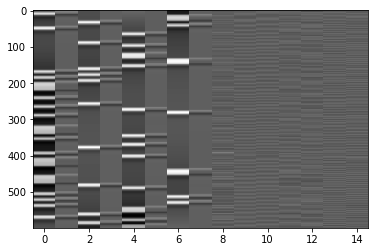

In [34]:
# This shows our study design
# What do each of the columns represent?
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

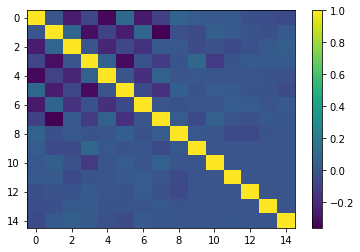

In [35]:
#Correlation matrix of our regressors 
#are any of them highly correlated? Would this be a problem?

cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()

In [36]:
#mask = mem.cache(fsl.maths.ApplyMask)
#mask_results = mask(in_file=skip_results.outputs.roi_file,
#                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
#                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
#                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-mni152nlin2009casym_brainmask.nii.gz"%(source_epi.subject,
#                                                                                                                             source_epi.session)))
#mask_results.outputs

In [37]:
skip = mem.cache(fsl.ExtractROI)
skip_results1 = skip(in_file=source_epi[0].path,t_min=500, t_size=-1)

191107-21:36:38,596 nipype.workflow INFO:
	 [Node] Setting-up "35ab2a3914957fd3d652576af313884d" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/35ab2a3914957fd3d652576af313884d".
191107-21:36:38,600 nipype.workflow INFO:
	 [Node] Cached "35ab2a3914957fd3d652576af313884d" - collecting precomputed outputs
191107-21:36:38,600 nipype.workflow INFO:
	 [Node] "35ab2a3914957fd3d652576af313884d" found cached.


In [38]:
#mask=layout.get(space='MNI152NLin2009cAsym',suffix='brainmask',extension="nii.gz")

In [39]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=source_epi[0].path,mask_file='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

191107-21:36:39,756 nipype.workflow INFO:
	 [Node] Setting-up "5029729351e114e8a65edcb6c71930ec" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5029729351e114e8a65edcb6c71930ec".
191107-21:36:39,759 nipype.workflow INFO:
	 [Node] Cached "5029729351e114e8a65edcb6c71930ec" - collecting precomputed outputs
191107-21:36:39,759 nipype.workflow INFO:
	 [Node] "5029729351e114e8a65edcb6c71930ec" found cached.


In [41]:
mask_results.outputs.out_file #show us the filename of our masked EPI

'/home/jovyan/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5029729351e114e8a65edcb6c71930ec/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc_masked.nii.gz'

In [42]:
#This section takes a LONG time. This may be as far as we make it during class today.
#While this is running - how many timepoints does it say we have? How many timeseries?
#Once this is done, how long did it take in total? How long do we need to allow to run all 3 runs for all participants?

#Actually fit the GLM to our data: see https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT/UserGuide#FILM_General_Linear_Model

filmgls = mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

191107-21:36:48,7 nipype.workflow INFO:
	 [Node] Setting-up "b204efc0eeacb74cb06eb9efa375645e" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e".
191107-21:36:48,12 nipype.workflow INFO:
	 [Node] Running "b204efc0eeacb74cb06eb9efa375645e" ("nipype.interfaces.fsl.model.FILMGLS"), a CommandLine Interface with command:
film_gls --noest --rn=results --con=/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9/run0.con --in=/home/jovyan/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5029729351e114e8a65edcb6c71930ec/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc_masked.nii.gz --pd=/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/d98e12c2e362a8940fffc3049ed5d4a9/run0.mat --thr=-1000.000000
191107-21:36:48,46 nipype.interface INFO:
	 stdout 2019-11-07T21:36:48.045897:Log directory is: results
191107-21:37:15,880 nipype.interface INFO:
	 stdout 2019-11-07T21:37:15.8801


copes = ['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope1.nii.gz', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope2.nii.gz', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope3.nii.gz', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope4.nii.gz', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope5.nii.gz']
dof_file = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/dof
fstats = <undefined>
logfile = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/logfile
param_estimates = ['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/pe1.nii.gz', '/home/jovyan/n

/opt/conda/lib/python3.7/site-packages/nilearn/plotting/displays.py:767: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


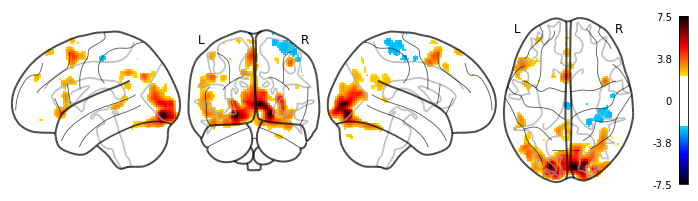

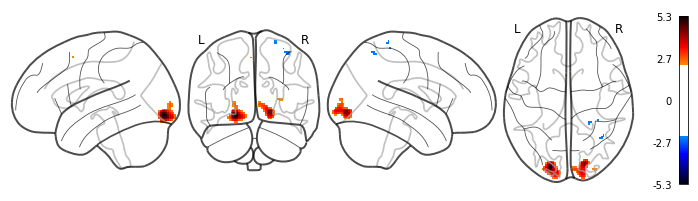

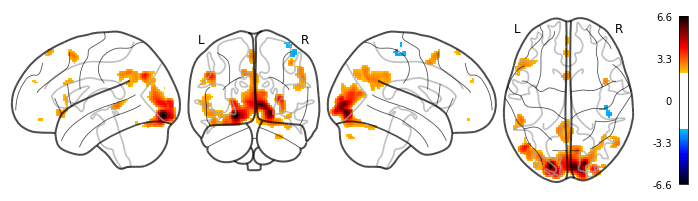

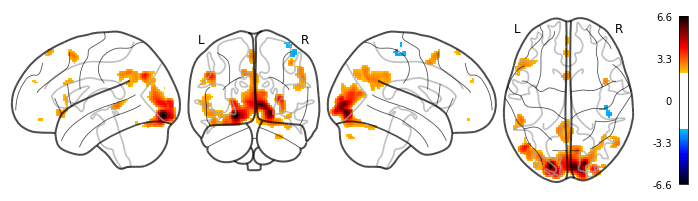

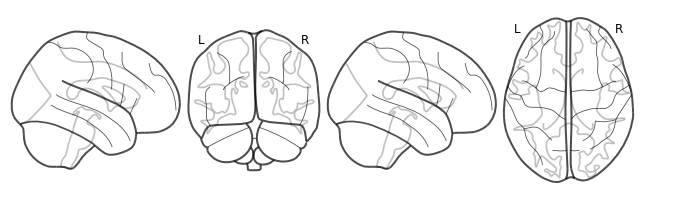

In [43]:
#This smooths each t map from our first run and displays them
for t_map in filmgls_results.outputs.zstats:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

In [44]:
#fstat
#for t_map in [filmgls_results.outputs.zfstats]:
#    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
#                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

In [45]:
filmgls_results.outputs.copes

['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope1.nii.gz',
 '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope2.nii.gz',
 '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope3.nii.gz',
 '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope4.nii.gz',
 '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/b204efc0eeacb74cb06eb9efa375645e/results/cope5.nii.gz']

In [46]:
#What are we talking about with copes in the code section below? 
#How did you define this in the script above?

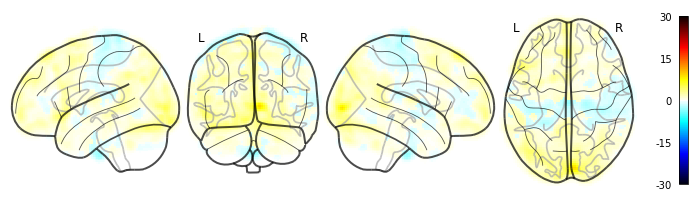

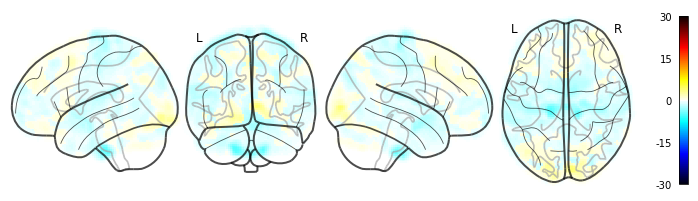

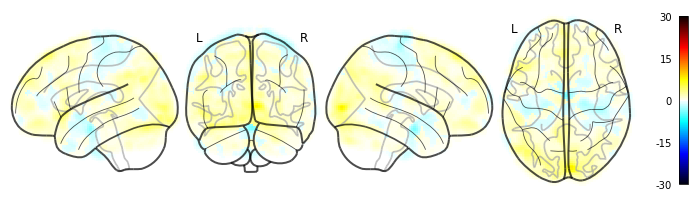

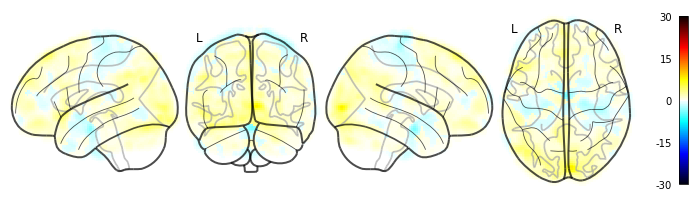

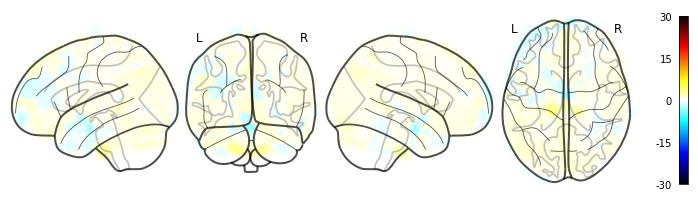

In [47]:
for t_map in filmgls_results.outputs.copes:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, vmax=30)

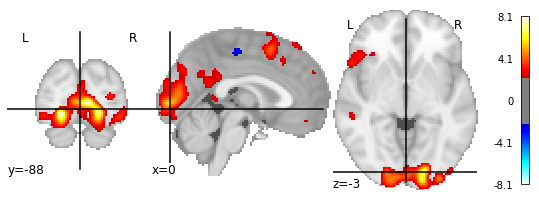

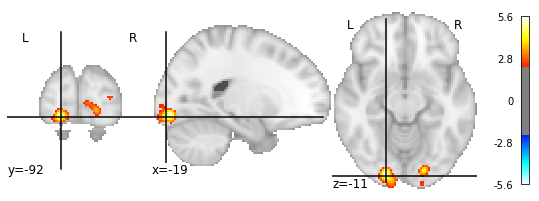

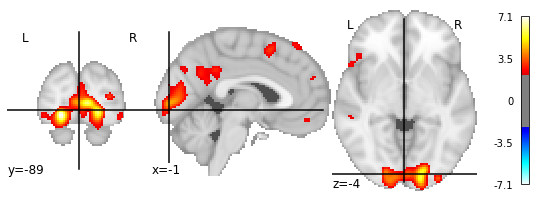

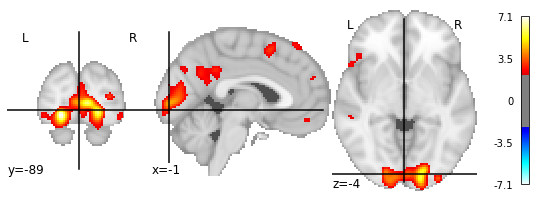

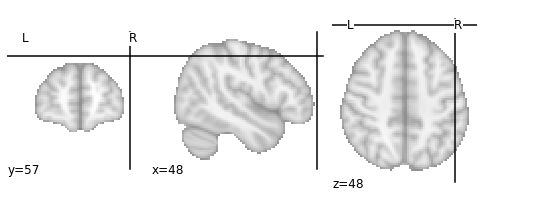

In [48]:
# How are the t-stats different from the cope? See slides 37-60
#https://fsl.fmrib.ox.ac.uk/fslcourse/lectures/feat1_part2.pdf
for t_map in filmgls_results.outputs.tstats:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3)

## Repeat for all subjects


In [69]:
import pandas as pd
#made a list of the onset files so we can load them for each run
onsets_file_list=[os.path.join(datadir, "onsets1.csv"),os.path.join(datadir, "onsets2.csv"),os.path.join(datadir, "onsets3.csv")]
j=1
events = pd.read_csv(onsets_file_list[j], sep=",")
events

,Event Number,trial_type,onset,duration
0,1,School,0.0,8.0
1,2,School,8.0,8.0
2,3,Career,16.0,8.0
3,4,Career,24.0,8.0
4,5,Career,32.0,8.0
...,...,...,...,...
70,71,School,560.0,8.0
71,72,School,568.0,8.0
72,73,Career,576.0,8.0
73,74,School,584.0,8.0


In [49]:
layout

BIDS Layout: .../home/jovyan/ClassData | Subjects: 10 | Sessions: 0 | Runs: 30

In [52]:
subjects=layout.get_subjects()

In [71]:
subjects

['sid000006',
 'sid000118',
 'sid000689',
 'sid000747',
 'sid001548',
 'sid001550',
 'sid001551',
 'sid001560',
 'sid001561',
 'sid001562']

In [56]:
len(subjects)

10

In [72]:
#if you want to drop a subject do that here - otherwise skip this line. 
#If you want to drop multiple subjects copy and paste this line and add another subject
subjects.remove('sid000006')

In [73]:
len(subjects)

9

In [ ]:
#Set contrasts here
#Contrasts are the relative weight of the parameter estimates (betas) for each condition

social_cond = ['Social','T', ['Social'],[1]]
event_cond = ['Event','T', ['Event'],[1]]
school_cond = ['School','T', ['School'],[1]]
career_cond = ['Career','T', ['Career'],[1]]
school_vs_others = ['School vs. others','T', ['School', 'Event', 'Social','Career'],[1, -1/3, -1/3, -1/3]]
contrasts=[social_cond, event_cond, school_cond, career_cond, school_vs_others]


In [99]:
import shutil

In [ ]:
copes = {}
t_map_list=[]
for i in range(len(subjects)):
    print('Processing subject '+subjects[i])
    subjectfiles=layout.get(subject=subjects[i],task="mental", extensions="nii",return_type='filename')
    confoundfiles=layout.get(task="mental", extensions="tsv",subject=subjects[i],return_type='filename')
    for j in range(len(subjectfiles)):
        print('Processing run '+str(j+1)+' for subject '+subjects[i])
        events = pd.read_csv(onsets_file_list[j], sep=",")
        print('Loaded events correctly')
        confounds=pd.read_csv(confoundfiles[j],sep="\t", na_values="n/a")
        print('Loaded confounds correctly')
        info = [Bunch(conditions=['Social',
                          'Event',
                          'School',
                          'Career'],
              onsets=[list(events[events.trial_type == 'Social'].onset),
                      list(events[events.trial_type == 'Event'].onset),
                      list(events[events.trial_type == 'School'].onset),
                      list(events[events.trial_type == 'Career'].onset)],
              durations=[list(events[events.trial_type == 'Social'].duration),
                          list(events[events.trial_type == 'Event'].duration),
                          list(events[events.trial_type == 'School'].duration),
                          list(events[events.trial_type == 'Career'].duration)],
             regressors=[list(confounds.FramewiseDisplacement.fillna(0)),
                         list(confounds.aCompCor00),
                         list(confounds.aCompCor01),
                         list(confounds.aCompCor02),
                         list(confounds.aCompCor03),
                         list(confounds.aCompCor04),
                         list(confounds.aCompCor05),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor00',
                              'aCompCor01',
                              'aCompCor02',
                              'aCompCor03',
                              'aCompCor04',
                              'aCompCor05',])
       ]
        source_epi=subjectfiles[j]
        #skip = mem.cache(fsl.ExtractROI)
        #skip_results = skip(in_file=source_epi,t_min=0, t_size=-1) #only load a small part into memory so we don't crash the server
        
        s = model.SpecifyModel()
        s.inputs.input_units = 'secs'
        s.inputs.functional_runs = source_epi #skip_results.outputs.roi_file
        s.inputs.time_repetition = 1 #1 second TR #layout.get_metadata(source_epi.filename)["RepetitionTime"]
        s.inputs.high_pass_filter_cutoff = 128.
        s.inputs.subject_info = info
        specify_model_results = s.run()
        s.inputs
        level1design = mem.cache(fsl.model.Level1Design)
        level1design_results = level1design(interscan_interval = 1,#layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                            bases = {'dgamma':{'derivs': True}},
                                            session_info = specify_model_results.outputs.session_info,
                                            model_serial_correlations=True,
                                            contrasts=contrasts)
        level1design_results.outputs
        modelgen = mem.cache(fsl.model.FEATModel)
        modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                                    ev_files=level1design_results.outputs.ev_files)
        modelgen_results.outputs    
        mask = mem.cache(fsl.maths.ApplyMask)
        mask_results = mask(in_file=source_epi,mask_file='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')
        print('Your masked EPI files is here:'+mask_results.outputs.out_file)
        print('Processing the GLM now, this will take a while')
        filmgls = mem.cache(fsl.FILMGLS)
        filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                                  design_file = modelgen_results.outputs.design_file,
                                  tcon_file = modelgen_results.outputs.con_file,
                                  fcon_file = modelgen_results.outputs.fcon_file,
                                  autocorr_noestimate = True)
        filmgls_results.outputs
        #add section here to rename stat files
        for index,t_map in enumerate(filmgls_results.outputs.zstats):
                source=t_map
                destination=results_dir+os.sep+subjects[i]+'_'+str(j+1)+'_'+contrasts[index][0]+'.nii'
                shutil.copy(source,destination)
                t_map_list.append(destination)

Processing subject sid000118
Processing run 1 for subject sid000118
Loaded events correctly
Loaded confounds correctly
191108-21:02:40,287 nipype.workflow INFO:
	 [Node] Setting-up "7b618a2c4348ec087870a2bd5a45fed2" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/7b618a2c4348ec087870a2bd5a45fed2".
191108-21:02:40,310 nipype.workflow INFO:
	 [Node] Cached "7b618a2c4348ec087870a2bd5a45fed2" - collecting precomputed outputs
191108-21:02:40,311 nipype.workflow INFO:
	 [Node] "7b618a2c4348ec087870a2bd5a45fed2" found cached.
191108-21:02:40,314 nipype.workflow INFO:
	 [Node] Setting-up "cec9f54207a6c948469456ea1866440c" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/cec9f54207a6c948469456ea1866440c".
191108-21:02:40,316 nipype.workflow INFO:
	 [Node] Cached "cec9f54207a6c948469456ea1866440c" - collecting precomputed outputs
191108-21:02:40,317 nipype.workflow INFO:
	 [Node] "cec9f54207a6c948469456ea1866440c" found cached.
191108-21:02:40,320 nipype.wor

## Please go into your output directory and see if the contrasts are there.

We will do subject and group level analyses with a different notebook